## Imports

In [1]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### 1. Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [2]:
# database connection
username = config.PG_USERNAME
password = config.PG_PASSWORD
database_name = config.DB_NAME

config_path = 'postgresql://{username}:{password}@{database_name}'.format(
    username = username,
    password = password,
    database_name = database_name
)

# schemas 
schema_name = 'eol_test' # all created tables will be created using this schema

# caching
reset_schema = False # if true, rebuild all data from scratch

# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

Executed 1 SQLs


/home/kodialam/.local/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index idx__loc_source_value
  "expression-based index %s" % idx_name


### 2. Example Query of an OMOP-standard Database
Wiki page of expected tables [here](https://github.com/OHDSI/CommonDataModel/wiki)

In [3]:
sql = """
    select 
        b.concept_name as concept_name,
        a.condition_source_value as concept_code
    from
        {omop_schema}.condition_occurrence a
    inner join
        {omop_schema}.concept b
    on 
        a.condition_concept_id = b.concept_id
    limit 100
""".format(
    omop_schema=config.OMOP_CDM_SCHEMA
)
output_df = db.query(sql)
display(output_df.head())

,concept_name,concept_code
0,Pure hypercholesterolemia,ICD9CM: 272.0
1,Benign prostatic hypertrophy with outflow obst...,ICD9CM: 600.01
2,Acute pharyngitis,ICD9CM: 462
3,Cellulitis and abscess of buttock,ICD9CM: 682.5
4,No matching concept,ICD9CM: 786.4


### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

In [37]:
cohort_name = '__eol_cohort'
cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'training_start_date'   : '2016-01-01',
          'training_end_date'     : '2017-01-01',
          'gap'                   : '3 months',
          'outcome_window'        : '6 months'
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

##### Build Cohort

In [38]:
cohort.build(db, replace=False)

Regenerating Table (replace=True)
Regenerated Cohort in 22.463050603866577 seconds


### Get a Time Series of Features for Cohort Members

In [41]:
featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs','conditions','procedures','specialty'],
    schema_name,
    cohort_name
)

In [42]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = '/tmp/cache_data_eol_test'
featureSet.build(cohort, from_cached=False, cache_file=cache_data_path)

Data loaded to buffer in 1445.19 seconds
Got Unique Concepts and Timestamps in 160.23 seconds
Created Index Mappings in 0.05 seconds
136795
Generated Sparse Representation of Data in 517.52 seconds
CPU times: user 10min 4s, sys: 2min 29s, total: 12min 34s
Wall time: 35min 23s


In [46]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet)

### Build a Model to Predict End of Life using this data

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [48]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet
)

CPU times: user 14min 58s, sys: 2min 40s, total: 17min 38s
Wall time: 17min 45s


#### Set up a standard sklearn modelling pipeline

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

lr = LogisticRegression(
    class_weight='balanced', C=0.02,
    penalty='l1', fit_intercept=True,
    solver='liblinear', random_state=0,
    verbose=0, max_iter = 200, tol=1e-1
)

def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

func = FunctionTransformer(
    func=tr_func,
    accept_sparse=True,
    validate=True,
    kw_args={'kwarg': 1}
)

# The classifier will transform each data point using func, which here takes a count vector to a binary vector
# Then, it will use logistic regression to classify the transformed data
clf = Pipeline([
    ('func',func),
    ('lr', lr)
])

#### Instantiate, Train and Test Model

In [63]:
indices = range(len(outcomes_filt))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    feature_matrix_counts.T, outcomes_filt, indices,
    test_size=0.2, random_state=1
)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
print('Model Test AUC: {0:.2f}'.format(roc_auc_score(y_test, pred)))

Model Test AUC: 0.80


#### Evaluate Model : RoC and Precision-Recall Curves

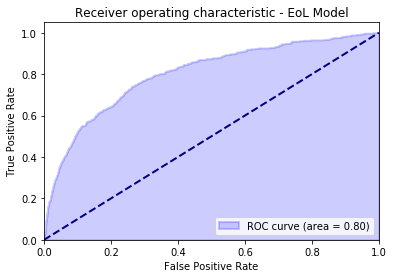

In [75]:
fpr, tpr, _ = roc_curve(y_test, pred)
plt.figure()
lw = 2
plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - EoL Model')
plt.legend(loc="lower right")
plt.show()

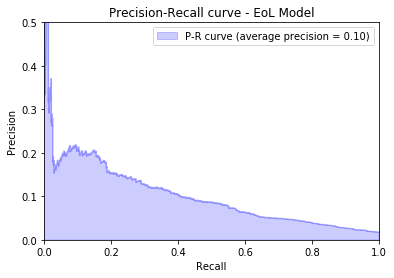

In [65]:
precision, recall, _ = precision_recall_curve(y_test, pred)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(
    recall, precision, alpha=0.2, color='b',
    label='P-R curve (average precision = %0.2f)' % average_precision
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall curve - EoL Model')
plt.show()

#### Evaluate Model : Extract Feature Weights

In [66]:
feature_weights = pd.DataFrame({
    'feature_name': feature_names,
    'feature_weight': list(clf.get_params()['lr'].coef_[0])
}).sort_values(by='feature_weight')
pd.set_option('display.max_colwidth', -1)

In [67]:
feature_weights.tail(20)

,feature_name,feature_weight
131710,4001171 - condition - Liver cell carcinoma - 730 days,0.441087
120087,"2211508 - procedure - Radiologic examination, abdomen; complete, including decubitus and/or erect views - 730 days",0.444479
63691,4152384 - condition - Non-rheumatic aortic sclerosis - 180 days,0.457767
77428,196925 - condition - Secondary malignant neoplasm of retroperitoneum and peritoneum - 365 days,0.464019
136610,4155034 - condition - Laceration of forearm - 730 days,0.464407
156125,"2111054 - procedure - Treatment of extensive or progressive retinopathy (eg, diabetic retinopathy), photocoagulation - 10000 days",0.473012
136643,4157389 - condition - Protein deficiency disease - 730 days,0.493533
147484,1719007 - drug - Osmotic 24 HR Nifedipine 30 MG Extended Release Oral Tablet - 10000 days,0.509225
139214,43011909 - drug - 12 HR Aspirin 25 MG / Dipyridamole 200 MG Extended Release Oral Capsule [Aggrenox] - 730 days,0.532505
175240,"42873649 - drug - 0.5 ML Influenza A virus vaccine, A-California-7-2009 (H1N1)-like virus 0.03 MG/ML / Influenza A virus vaccine, A-Victoria-361-2011 (H3N2)-like virus 0.03 MG/ML / Influenza B virus vaccine, B-Wisconsin-1-2010-like virus 0.03 MG/ML Prefilled Syringe [Fluar - 10000 days",0.549499


In [68]:
feature_weights.head(20)

,feature_name,feature_weight
84104,"2213282 - procedure - Level III - Surgical pathology, gross and microscopic examination Abortion, induced Abscess Aneurysm - arterial/ventricular Anus, tag Appendix, other than incidental Artery, atheromatous plaque Bartholin's gland cyst Bone fragment(s), other than pathologi - 365 days",-0.869867
177139,43528020 - procedure - Nerve conduction studies; 9-10 studies - 10000 days,-0.651872
118438,"2109194 - procedure - Colonoscopy, flexible; diagnostic, including collection of specimen(s) by brushing or washing, when performed (separate procedure) - 730 days",-0.552424
48359,"2514405 - procedure - Initial hospital care, per day, for the evaluation and management of a patient, which requires these 3 key components: A comprehensive history; A comprehensive examination; and Medical decision making of moderate complexity. Counseling and/or coordination - 180 days",-0.550425
177317,"43533326 - procedure - Carrying, moving and handling objects, projected goal status, at therapy episode outset, at reporting intervals, and at discharge or to end reporting - 10000 days",-0.505235
173429,4184592 - procedure - Aortography - 10000 days,-0.501241
157738,"2514528 - procedure - Periodic comprehensive preventive medicine reevaluation and management of an individual including an age and gender appropriate history, examination, counseling/anticipatory guidance/risk factor reduction interventions, and the ordering of laboratory/diag - 10000 days",-0.478271
149786,19135223 - drug - Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet [Benicar HCT] - 10000 days,-0.463479
84618,"2314215 - procedure - Therapeutic, prophylactic, or diagnostic injection (specify substance or drug); intravenous push, single or initial substance/drug - 365 days",-0.461951
175126,"42800464 - drug - 0.5 ML Bordetella pertussis filamentous hemagglutinin vaccine, inactivated 0.01 MG/ML / Bordetella pertussis fimbriae 2/3 vaccine, inactivated 0.01 MG/ML / Bordetella pertussis pertactin vaccine, inactivated 0.006 MG/ML / Bordetella pertussis toxoid vacci - 10000 days",-0.450040


In [69]:
for category in ['procedure', 'condition', 'drug', 'specialty']:
    print('Number of nonzero {} feature weights : {}'.format(
        category,
        sum(feature_weights.loc[
            [i for i,j in enumerate(feature_names) if '- ' + category + ' -' in j]
        ]['feature_weight'] != 0)
    ))

Number of nonzero procedure feature weights : 488
Number of nonzero condition feature weights : 744
Number of nonzero drug feature weights : 321
